<a href="https://www.kaggle.com/code/kyeongsupchoi/model2-1?scriptVersionId=132735400" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 프로젝트 소개
* [프로젝트 소개](#introduction)
* [1 단계: 탐색적 데이터 분석](#step-one)
* [2 단계: 모델 학습](#step-two)
* [3 단계: 모델 검증](#step-three)

In [1]:
# Synthetic dataset
from sklearn.datasets import make_classification
# Data processing
import pandas as pd
import numpy as np
from collections import Counter
# Visualization
import matplotlib.pyplot as plt
# Model and performance
from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

<a id="step-one"></a>
# **1 단계: 탐색적 데이터 분석** 

csv에서 데이터를 읽고 데이터 프레임에 로드

In [2]:
# 불균형 데이터셋 생성
X, y = make_classification(n_samples=100000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           weights=[0.995, 0.005],
                           class_sep=0.5, random_state=0)

# numpy 배열를 pandas 데이터프레임으로 변환
df = pd.DataFrame({'feature1': X[:, 0], 'feature2': X[:, 1], 'target': y})

# 목표 분포 확인
df['target'].value_counts(normalize = True)

0    0.9897
1    0.0103
Name: target, dtype: float64

<a id="step-two"></a>
# **2 단계: 모델 학습**

In [3]:
# 훈련 테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 레코드 수 확인
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 80000
The number of records in the test dataset is 20000
The training dataset has 79183 records for the majority class and 817 records for the minority class.


In [4]:
# 단일 클래스 SVM(Support Vector Machine) 모델 훈련
one_class_svm = OneClassSVM(nu=0.01, kernel = 'rbf', gamma = 'auto').fit(X_train)

In [5]:
# 이상 현상 예측
prediction = one_class_svm.predict(X_test)

# TRUE 값과 일치하도록 변칙 값을 변경합니다.
prediction = [1 if i==-1 else 0 for i in prediction]

# 모델 성능 확인
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19787
           1       0.06      0.06      0.06       213

    accuracy                           0.98     20000
   macro avg       0.53      0.53      0.53     20000
weighted avg       0.98      0.98      0.98     20000



In [6]:
# Get the scores for the testing dataset
score = one_class_svm.score_samples(X_test)
# Check the score for 2% of outliers
score_threshold = np.percentile(score, 2)
print(f'The customized score threshold for 2% of outliers is {score_threshold:.2f}')
# Check the model performance at 2% threshold
customized_prediction = [1 if i < score_threshold else 0 for i in score]
# # Check the prediction performance
print(classification_report(y_test, customized_prediction))

The customized score threshold for 2% of outliers is 182.62
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     19787
           1       0.06      0.10      0.07       213

    accuracy                           0.97     20000
   macro avg       0.52      0.54      0.53     20000
weighted avg       0.98      0.97      0.98     20000



<a id="step-three"></a>
# **3 단계: 모델 검증**

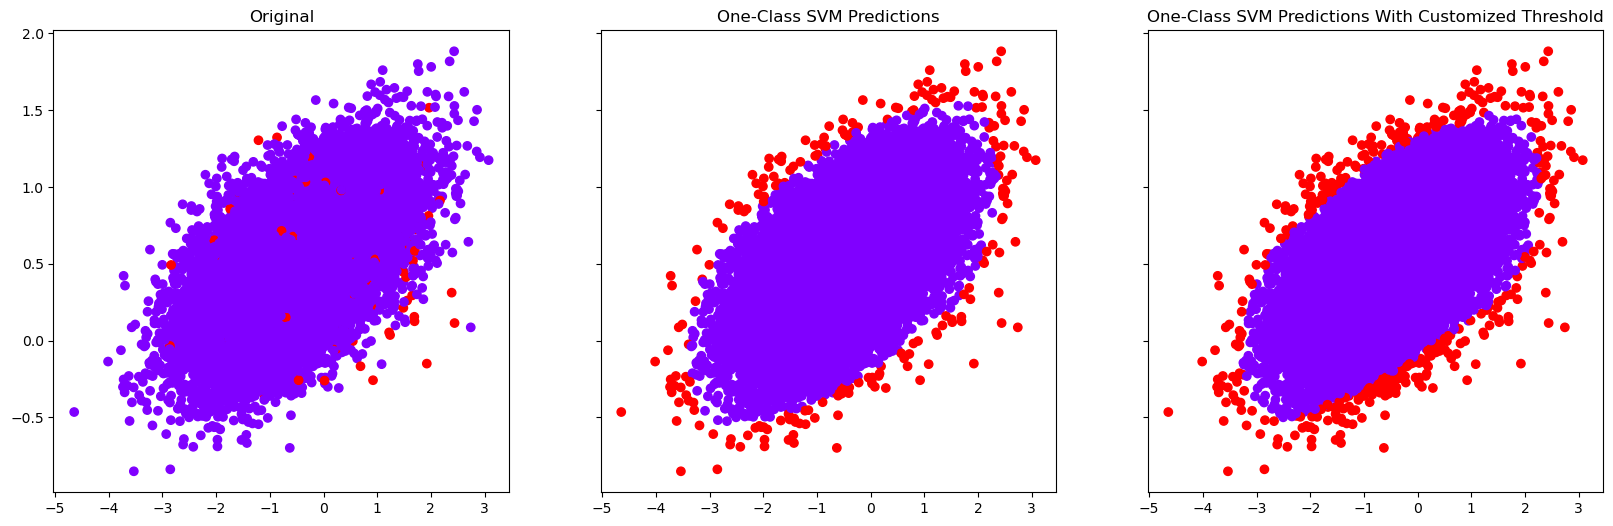

In [7]:
# 테스트 데이터 세트와 예측을 동일한 데이터 프레임에 넣습니다.
df_test = pd.DataFrame(X_test, columns=['feature1', 'feature2'])
df_test['y_test'] = y_test
df_test['one_class_svm_prediction'] = prediction
df_test['one_class_svm_prediction_cutomized'] = customized_prediction

# 실제 및 예측된 이상 징후 시각화
fig, (ax0, ax1, ax2)=plt.subplots(1,3, sharey=True, figsize=(20,6))

# 실측
ax0.set_title('Original')
ax0.scatter(df_test['feature1'], df_test['feature2'], c=df_test['y_test'], cmap='rainbow')

# 단일 클래스 SVM 예측
ax1.set_title('One-Class SVM Predictions')
ax1.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction'], cmap='rainbow')

# 사용자 지정된 임계값을 사용한 단일 클래스 SVM 예측
ax2.set_title('One-Class SVM Predictions With Customized Threshold')
ax2.scatter(df_test['feature1'], df_test['feature2'], c=df_test['one_class_svm_prediction_cutomized'], cmap='rainbow')